In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed


import numpy as np # linear algebra
import pandas as pd 
import os

In [5]:
data_path = r"D:\project1\pythonProject\gh\data_source"

for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:\project1\pythonProject\gh\data_source\GlobalLandTemperaturesByCity.csv
D:\project1\pythonProject\gh\data_source\GlobalLandTemperaturesByCountry.csv
D:\project1\pythonProject\gh\data_source\GlobalLandTemperaturesByMajorCity.csv
D:\project1\pythonProject\gh\data_source\GlobalLandTemperaturesByState.csv
D:\project1\pythonProject\gh\data_source\GlobalTemperatures.csv


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [9]:
class TemperatureAnalysis:
    def __init__(self):
        self.df = None
        self.yearly_data = None
        self.scaler = MinMaxScaler()
        self.lstm_model = None
        self.lr_model = None
        self.sequence_length = 12
    def process_data(self):
            """Load and preprocess data"""
            filepath = "D:\project1\pythonProject\gh\data_source\GlobalTemperatures.csv"
            print(f"Loading data from {filepath}...")
    
            temperatures = pd.read_csv(filepath)
            temperatures.index = pd.to_datetime(temperatures.dt)
            temperatures = temperatures.drop(columns=['dt'])
            temperatures['Year'] = temperatures.index.year
    
            self.yearly_data = temperatures['LandAverageTemperature'].asfreq('Y')
            yearly_mean = self.yearly_data.resample('Y').mean()
    
            self.df = temperatures.resample('Y').mean()
    
            print(f"Data loaded. Time range: {self.df.index.min().year} - {self.df.index.max().year}")
            return self.df

    def train_linear_regression(self, start_year=None):
        """Train linear regression model"""
        if start_year:
            data = self.df[self.df.index.year >= start_year]
        else:
            data = self.df

        corr, p = pearsonr(data.index.year, data['LandAverageTemperature'])
        print(f'Pearson correlation of Year and Land Average Temperature: {corr}')

        lr = LinearRegression()
        X = data.index.year.values.reshape(-1,1)
        y = data['LandAverageTemperature']

        lr.fit(X, y)
        y_pred = lr.predict(X)

        plt.figure(figsize=(18,10))
        plt.scatter(X, y, alpha=0.6)
        plt.plot(X, y_pred, color="orange")
        plt.xlabel('Years')
        plt.ylabel('Temperature (in °C)')
        plt.title(f'Linear Regression ({start_year or 1750}-2015)')
        plt.show()
        plt.clf()

        print(f"\nTemperature change per year: {lr.coef_[0]:.4f}°C")
        print(f"Temperature change per decade: {lr.coef_[0] * 10:.4f}°C")

        future_temps = lr.predict(np.array([2030, 2050]).reshape(-1,1))
        print(f"\nPredicted temperatures:")
        print(f"2030: {future_temps[0]:.3f}°C")
        print(f"2050: {future_temps[1]:.3f}°C")

        self.lr_model = lr
        return lr

    def create_sequences(self, data):
        """Create sequences for LSTM input"""
        X = []
        for i in range(len(data) - self.sequence_length):
            X.append(data[i:(i + self.sequence_length)])
        return np.array(X)

    def train_lstm(self, lookback=12):
        """Train LSTM model"""
        data = self.df['LandAverageTemperature'].values.reshape(-1, 1)
        scaled_data = self.scaler.fit_transform(data)

        X, y = [], []
        for i in range(len(scaled_data) - lookback):
            X.append(scaled_data[i:(i + lookback)])
            y.append(scaled_data[i + lookback])
        X, y = np.array(X), np.array(y)

        train_size = int(len(X) * 0.8)
        X_train = X[:train_size]
        y_train = y[:train_size]
        X_test = X[train_size:]
        y_test = y[train_size:]

        model = Sequential([
            LSTM(50, activation='relu', input_shape=(lookback, 1), return_sequences=True),
            Dropout(0.2),
            LSTM(50, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse')

        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_split=0.1,
            verbose=1
        )

        self.lstm_model = model
        return model, history

    def evaluate_models(self):
        """Evaluate all model performance"""
        metrics = {}

        if self.df is None:
            raise ValueError("Data must be loaded first")

        actual = self.df['LandAverageTemperature'].values

        if self.lr_model is not None:
            lr_pred = self.lr_model.predict(self.df.index.year.values.reshape(-1,1))
            metrics['Linear Regression'] = {
                'MSE': mean_squared_error(actual, lr_pred),
                'RMSE': np.sqrt(mean_squared_error(actual, lr_pred)),
                'MAE': mean_absolute_error(actual, lr_pred),
                'R2': r2_score(actual, lr_pred),
                'MAPE': np.mean(np.abs((actual - lr_pred) / actual)) * 100
            }

        if self.lstm_model is not None:
            X = self.create_sequences(self.scaler.transform(actual.reshape(-1,1)))
            lstm_pred = self.lstm_model.predict(X)
            lstm_pred = self.scaler.inverse_transform(lstm_pred)

            actual_lstm = actual[self.sequence_length:]
            metrics['LSTM'] = {
                'MSE': mean_squared_error(actual_lstm, lstm_pred),
                'RMSE': np.sqrt(mean_squared_error(actual_lstm, lstm_pred)),
                'MAE': mean_absolute_error(actual_lstm, lstm_pred),
                'R2': r2_score(actual_lstm, lstm_pred),
                'MAPE': np.mean(np.abs((actual_lstm - lstm_pred.flatten()) / actual_lstm)) * 100
            }

        for model_name, model_metrics in metrics.items():
            print(f"\n{model_name} Performance Metrics:")
            for metric_name, value in model_metrics.items():
                print(f"{metric_name}: {value:.4f}")

        return metrics

    def plot_temperature_heatmap(self):
        """Plot heatmap of temperature data"""
        monthly_temps = self.df.copy()
        monthly_temps['Month'] = monthly_temps.index.month
        monthly_temps['Year'] = monthly_temps.index.year
        pivot_temps = monthly_temps.pivot('Year', 'Month', 'LandAverageTemperature')

        plt.figure(figsize=(15, 8))
        sns.heatmap(pivot_temps, 
                    cmap='RdYlBu_r',
                    center=pivot_temps.mean().mean(),
                    annot=False,
                    fmt='.1f',
                    cbar_kws={'label': 'Temperature (°C)'})
        plt.title('Temperature Heatmap by Year and Month')
        plt.xlabel('Month')
        plt.ylabel('Year')
        plt.show()

    def plot_advanced_visualizations(self):
        """Create advanced visualization charts"""
        plt.figure(figsize=(20, 15))

        plt.subplot(2, 2, 1)
        plt.fill_between(self.df.index,
                        self.df['LandAverageTemperature'] - self.df['LandAverageTemperatureUncertainty'],
                        self.df['LandAverageTemperature'] + self.df['LandAverageTemperatureUncertainty'],
                        alpha=0.2)
        plt.plot(self.df.index, self.df['LandAverageTemperature'], 'b-')
        plt.title('Temperature Trend with Uncertainty')
        plt.xlabel('Year')
        plt.ylabel('Temperature (°C)')

        plt.subplot(2, 2, 2)
        sns.boxplot(data=self.df, y='LandAverageTemperature')
        plt.title('Temperature Distribution')
        plt.ylabel('Temperature (°C)')

        plt.subplot(2, 2, 3)
        temp_changes = self.df['LandAverageTemperature'].diff()
        sns.histplot(temp_changes, kde=True)
        plt.title('Temperature Change Distribution')
        plt.xlabel('Temperature Change (°C)')

        plt.subplot(2, 2, 4)
        seasonal = self.df['LandAverageTemperature'].groupby(self.df.index.month).mean()
        seasonal.plot(kind='bar')
        plt.title('Average Temperature by Month')
        plt.xlabel('Month')
        plt.ylabel('Temperature (°C)')

        plt.tight_layout()
        plt.show()

    def create_comparison_plot(self):
        """Create prediction comparison plot"""
        if self.lr_model is None or self.lstm_model is None:
            raise ValueError("Train both models first")

        plt.figure(figsize=(15, 8))

        actual = self.df['LandAverageTemperature']
        plt.plot(self.df.index, actual, 
                label='Actual', color='black', alpha=0.6)

        lr_pred = self.lr_model.predict(self.df.index.year.values.reshape(-1,1))
        plt.plot(self.df.index, lr_pred, 
                label='Linear Regression', color='blue', linestyle='--')

        X_lstm = self.create_sequences(self.scaler.transform(actual.values.reshape(-1,1)))
        lstm_pred = self.lstm_model.predict(X_lstm)
        lstm_pred = self.scaler.inverse_transform(lstm_pred)

        lstm_index = self.df.index[self.sequence_length:]
        plt.plot(lstm_index, lstm_pred, 
                label='LSTM', color='red', linestyle='--')

        plt.title('Model Predictions Comparison')
        plt.xlabel('Year')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.grid(True)
        plt.show()



初始化分析器...

加载和处理数据...
Loading data from D:\project1\pythonProject\gh\data_source\GlobalTemperatures.csv...
Data loaded. Time range: 1750 - 2015

训练线性回归模型...
Pearson correlation of Year and Land Average Temperature: 0.6223364823755806


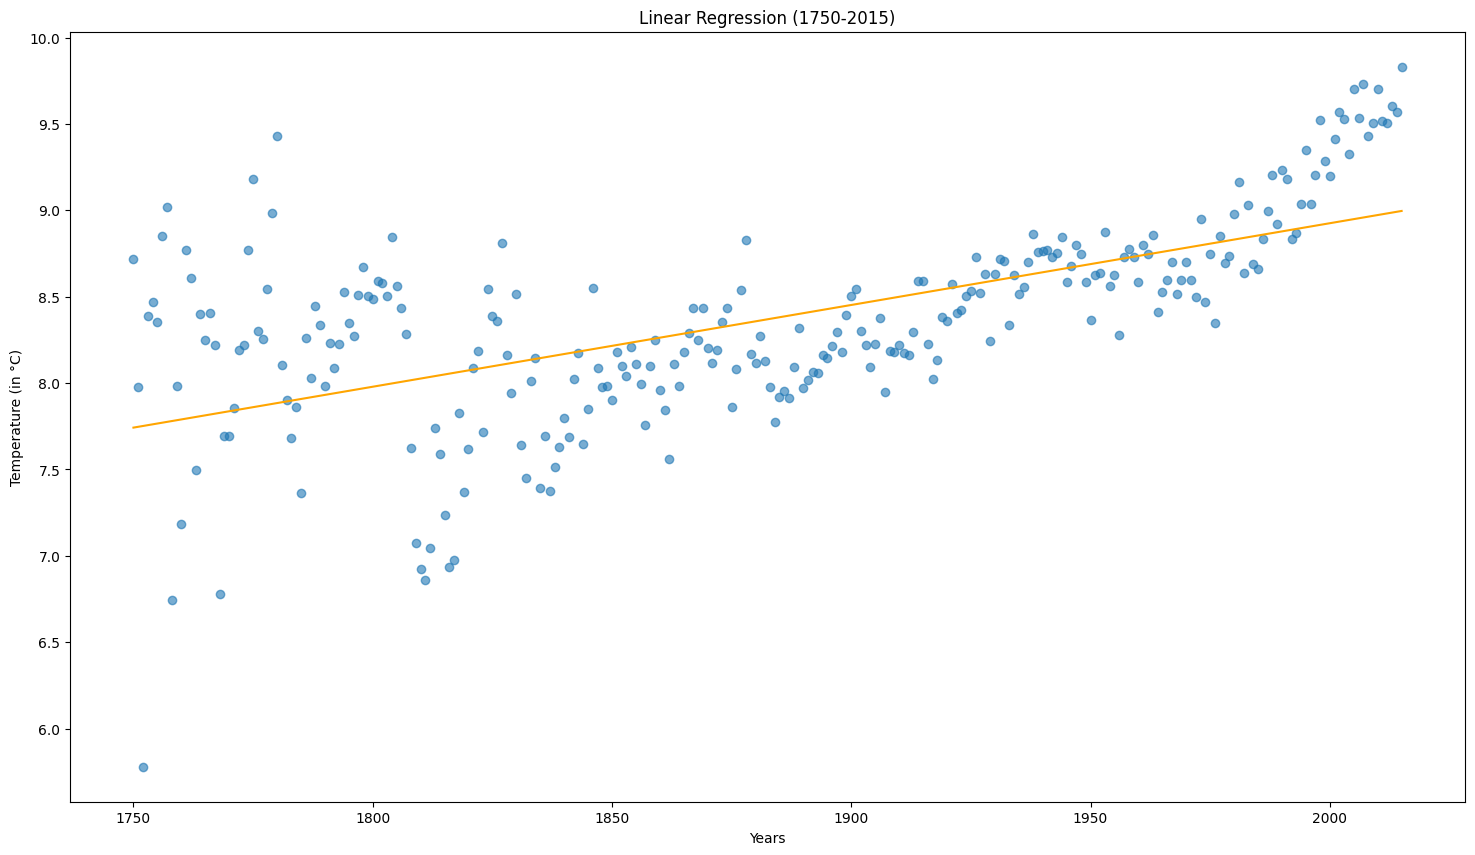


Temperature change per year: 0.0047°C
Temperature change per decade: 0.0473°C

Predicted temperatures:
2030: 9.067°C
2050: 9.162°C

训练LSTM模型...
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.3063 - val_loss: 0.3550
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2277 - val_loss: 0.2120
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1200 - val_loss: 0.0464
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0285 - val_loss: 0.0196
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0348 - val_loss: 0.0017
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0168 - val_loss: 0.0158
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0207 - val_loss: 0.0161
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0185 - val_loss: 0.0047
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0165 - val_loss: 0.0020
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0161 - val_loss: 0.0049
Epoch 11/100
6/6 ━━━

<Figure size 640x480 with 0 Axes>

In [10]:
print("初始化分析器...")
analyzer = TemperatureAnalysis()

print("\n加载和处理数据...")
df = analyzer.process_data()

print("\n训练线性回归模型...")
analyzer.train_linear_regression()

print("\n训练LSTM模型...")
analyzer.train_lstm()

print("\n评估模型性能...")
metrics = analyzer.evaluate_models()